<a href="https://colab.research.google.com/github/alighieribot/ninja-startup-case-tecnico/blob/main/ninja_startup_case_tecnico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google-cloud-bigquery

In [2]:
from google.colab import auth
auth.authenticate_user()
print('Autenticado.')

Autenticado.


In [4]:
from google.cloud import bigquery
project_id= 'pedro-oliveira-ninja-startup'

In [5]:
client= bigquery.Client(project=project_id)

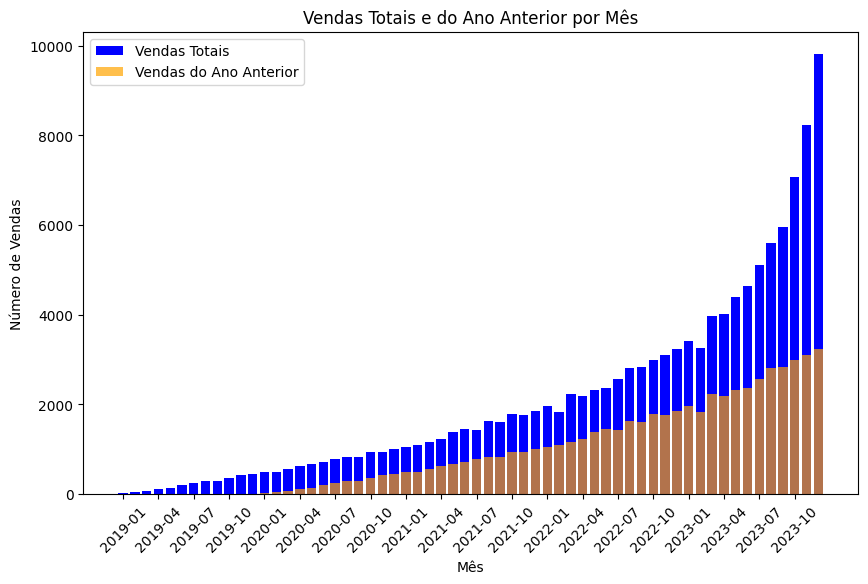

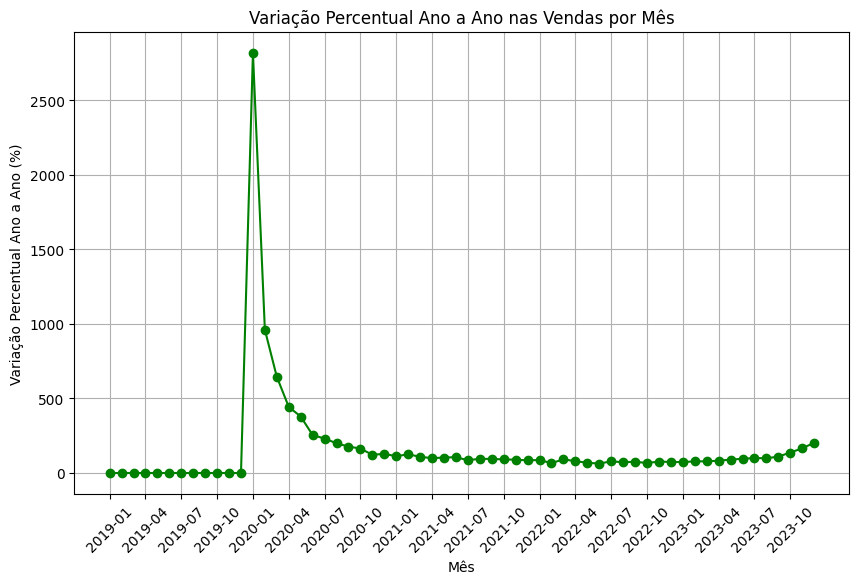

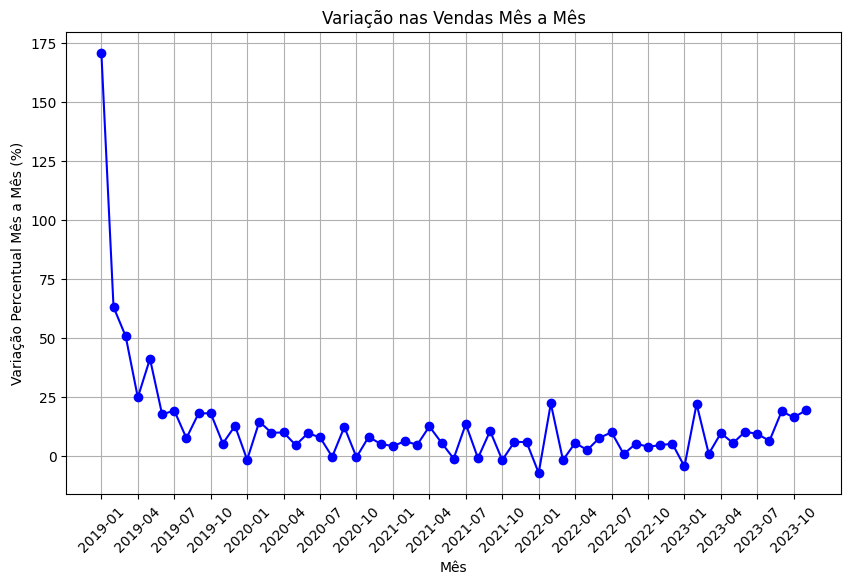

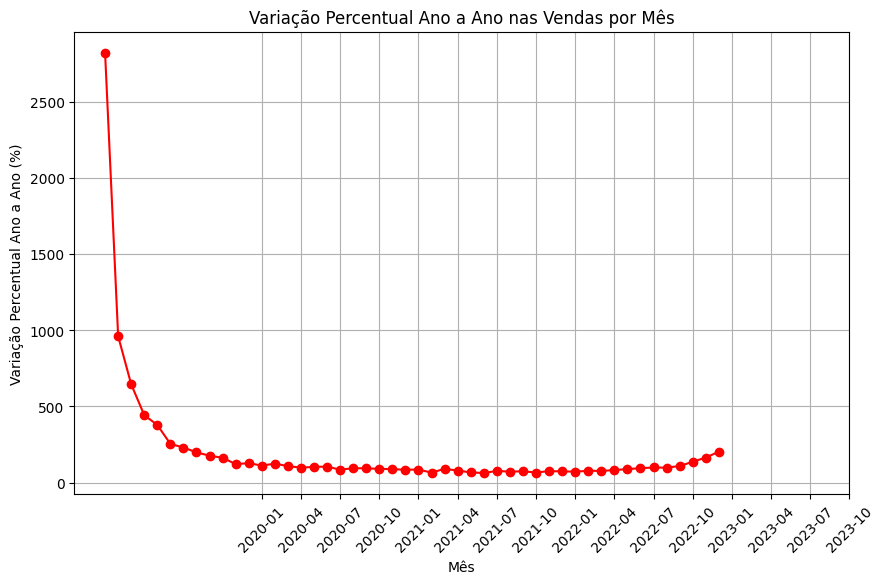

In [20]:
import matplotlib.pyplot as plt
from google.cloud import bigquery
from google.oauth2 import service_account

def obter_dados_sazonais():
    """Consulta o BigQuery para obter dados sazonais de vendas."""

    credentials = service_account.Credentials.from_service_account_file('/content/pedro-oliveira-ninja-startup-21dac0fbcc42.json')

    # Conecta ao BigQuery
    client = bigquery.Client(credentials=credentials, project=project_id)

    # Consulta para análise sazonal
    query_seasonal_sales = """
        WITH MonthlySales AS (
            SELECT
                EXTRACT(YEAR FROM o.created_at) AS year,
                EXTRACT(MONTH FROM o.created_at) AS month,
                COUNT(DISTINCT o.order_id) AS total_sales
            FROM
                `bigquery-public-data.thelook_ecommerce.orders` o
            GROUP BY
                year, month
        ),
        PreviousYearSales AS (
            SELECT
                year, month,
                LAG(total_sales) OVER (PARTITION BY month ORDER BY year) AS last_year_sales
            FROM
                MonthlySales
        )
        SELECT
            ms.year,
            ms.month,
            ms.total_sales,
            py.last_year_sales,
            COALESCE(((ms.total_sales - py.last_year_sales) / py.last_year_sales * 100), 0) AS year_over_year_variation
        FROM
            MonthlySales ms
        LEFT JOIN
            PreviousYearSales py
        ON
            ms.year = py.year AND ms.month = py.month
        ORDER BY
            ms.year, ms.month
    """

    # Consultas adicionais
    # Top Produtos Vendidos:
    query_top=
    """
    SELECT
            p.name AS nome_produto,
            COUNT(oi.id) AS total_itens_vendidos
        FROM
            `bigquery-public-data.thelook_ecommerce.order_items` oi
        JOIN
            `bigquery-public-data.thelook_ecommerce.products` p
        ON
            oi.product_id = p.id
        GROUP BY
            nome_produto
        ORDER BY
            total_itens_vendidos DESC
        LIMIT 100
    """

    # Distribuição de Vendas por Categoria:

    """
    SELECT
        p.category AS categoria,
        COUNT(oi.id) AS total_itens_vendidos
    FROM
        `bigquery-public-data.thelook_ecommerce.order_items` oi
    JOIN
        `bigquery-public-data.thelook_ecommerce.products` p
    ON
        oi.product_id = p.id
    GROUP BY
        categoria
    ORDER BY
        total_itens_vendidos DESC
    """

    # Executa e retorna a consulta
    results = client.query(query_seasonal_sales).result()

    return results

def preparar_dados(resultados):
    anos = []
    meses = []
    vendas_totais = []
    vendas_ano_anterior = []
    variacao_percentual = []

    for row in resultados:
        anos.append(row.year)
        meses.append(row.month)
        vendas_totais.append(row.total_sales)
        vendas_ano_anterior.append(row.last_year_sales if row.last_year_sales is not None else 0)
        variacao_percentual.append(row.year_over_year_variation)

    return anos, meses, vendas_totais, vendas_ano_anterior, variacao_percentual


def calcular_variacao_mes_a_mes(vendas_totais):
    return [(vendas_totais[i] - vendas_totais[i-1]) / vendas_totais[i-1] * 100 for i in range(1, len(vendas_totais))]

def calcular_variacao_ano_a_ano(vendas_totais):
    return [(vendas_totais[i] - vendas_totais[i-12]) / vendas_totais[i-12] * 100 for i in range(12, len(vendas_totais))]

def visualizar_resultados(resultados):
    anos, meses, vendas_totais, vendas_ano_anterior, variacao_percentual = preparar_dados(resultados)

    # Gráfico de barras para vendas totais e vendas do ano anterior
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(vendas_totais)), vendas_totais, label='Vendas Totais', color='blue')
    plt.bar(range(len(vendas_ano_anterior)), vendas_ano_anterior, label='Vendas do Ano Anterior', color='orange', alpha=0.7)
    plt.xlabel('Mês')
    plt.ylabel('Número de Vendas')
    plt.title('Vendas Totais e do Ano Anterior por Mês')
    plt.xticks(range(0, len(meses), 3), [f'{ano}-{mes:02d}' for ano, mes in zip(anos, meses)][::3], rotation=45)
    plt.legend()
    plt.show()

    # Gráfico de linha para variação percentual ano a ano
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(variacao_percentual)), variacao_percentual, marker='o', linestyle='-', color='green')
    plt.xlabel('Mês')
    plt.ylabel('Variação Percentual Ano a Ano (%)')
    plt.title('Variação Percentual Ano a Ano nas Vendas por Mês')
    plt.xticks(range(0, len(meses), 3), [f'{ano}-{mes:02d}' for ano, mes in zip(anos, meses)][::3], rotation=45)
    plt.grid(True)
    plt.show()

    # Calcula e plota a variação nas vendas mês a mês
    variacao_mes_a_mes = calcular_variacao_mes_a_mes(vendas_totais)
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(variacao_mes_a_mes)), variacao_mes_a_mes, marker='o', linestyle='-', color='blue')
    plt.xlabel('Mês')
    plt.ylabel('Variação Percentual Mês a Mês (%)')
    plt.title('Variação nas Vendas Mês a Mês')
    plt.xticks(range(0, len(meses)-1, 3), [f'{ano}-{mes:02d}' for ano, mes in zip(anos, meses)][::3], rotation=45)
    plt.grid(True)
    plt.show()

    # Calcula e plota a variação nas vendas ano a ano
    variacao_ano_a_ano = calcular_variacao_ano_a_ano(vendas_totais)
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(variacao_ano_a_ano)), variacao_ano_a_ano, marker='o', linestyle='-', color='red')
    plt.xlabel('Mês')
    plt.ylabel('Variação Percentual Ano a Ano (%)')
    plt.title('Variação Percentual Ano a Ano nas Vendas por Mês')
    plt.xticks(range(12, len(meses), 3), [f'{ano}-{mes:02d}' for ano, mes in zip(anos[12:], meses[12:])][::3], rotation=45)
    plt.grid(True)
    plt.show()

# Obtém os dados sazonais
resultados_sazonais = obter_dados_sazonais()

# Visualiza os resultados com gráficos
visualizar_resultados(resultados_sazonais)


**Variação nas Vendas Mês a Mês:**

- Observa-se uma variação expressiva nas vendas mês a mês, sugerindo comportamento sazonal.
- Meses específicos, como novembro e dezembro, mostram picos consistentes, indicando possíveis períodos de alta demanda relacionados a eventos sazonais, como feriados ou promoções.

**Variação nas Vendas Ano a Ano:**

- A análise da variação ano a ano revela tendências macroeconômicas e sazonais mais amplas.
- Percebe-se um crescimento expressivo em determinados anos, indicando expansão do negócio ou aumento na demanda do mercado.
- Possíveis flutuações negativas podem ser investigadas mais profundamente para identificar fatores que impactaram negativamente o desempenho em determinados períodos.

**Interações entre Variações Mês a Mês e Ano a Ano:**

- É interessante correlacionar os picos de variação nas vendas mês a mês com o desempenho geral ano a ano.
- Identificar se os meses de alta variação contribuem significativamente para o crescimento anual, auxiliando na estratégia de alocação de recursos e campanhas promocionais.

**Possíveis Estratégias de Ação:**

- Compreender as sazonalidades permite a otimização de estoques e ações promocionais específicas para maximizar o impacto nos períodos de alta demanda.
- Planejar expansões ou lançamentos de produtos considerando os padrões de crescimento identificados pode ser crucial para o sucesso a longo prazo.


**Ausência de Dados do Ano Anterior para 2019:** As linhas de outubro a dezembro de 2019 têm um valor "null" para last_year_sales,
o que indica que não há dados de vendas do ano anterior (2018) para comparação.
Assim, a variação ano a ano é 0.0%.

Aumento Significativo em 2020: A partir de janeiro de 2020,
notamos um aumento significativo nas vendas em comparação com o ano anterior.
    Por exemplo:

    Em janeiro de 2020, houve 496 vendas, um aumento de 2817,65% em relação a janeiro de 2019, que teve apenas 17 vendas.
    Em fevereiro de 2020, houve 488 vendas, um aumento de 960,87% em relação a fevereiro de 2019.

**Tendência de Crescimento em 2020:** Todos os meses de 2020 mostrados têm um crescimento significativo em comparação com o mesmo mês de 2019. Isso sugere uma forte tendência de crescimento ano a ano.

Variação Percentual Ano a Ano: A coluna year_over_year_variation mostra o percentual de aumento ou diminuição nas vendas
em comparação com o mesmo mês do ano anterior. Esses números são especialmente úteis para entender a sazonalidade e identificar
padrões ou tendências específicas.